In [4]:
# Testing GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6294352049062816708
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16976005310613339893
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5739991024350893745
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5186899666220669068
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [5]:
# Upload Compressed data and then to extract run this cell
!unzip /content/train_max_x.zip

Archive:  /content/train_max_x.zip
  inflating: train_max_x             


In [0]:
!pip install tensorflow==1.13.1

     |████████████████████████████████| 92.5MB 84kB/s 
     |████████████████████████████████| 3.2MB 43.9MB/s 
     |████████████████████████████████| 368kB 43.9MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
!pip install keras==2.2.4


     |████████████████████████████████| 317kB 2.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
import numpy as np
import cv2
import tensorflow as tf
from keras.datasets import mnist 
from keras.models import Model, Sequential 
from keras.layers import Dense, Input
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten 
from keras import backend as k 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications import InceptionResNetV2
from keras.utils.np_utils import to_categorical   
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from tqdm import tqdm_notebook
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from keras.utils import np_utils

In [7]:
print('Tensorflow', tf.__version__)
print('Keras', keras.__version__)

Tensorflow 1.15.0
Keras 2.2.5


In [0]:
train_images = pd.read_pickle('train_max_x')

In [0]:
labels = pd.read_csv('train_max_y.csv')

In [65]:
labels.head(5)

,Id,Label
0,0,6
1,1,7
2,2,2
3,3,9
4,4,7


In [0]:
test_images = pd.read_pickle('test_max_x')

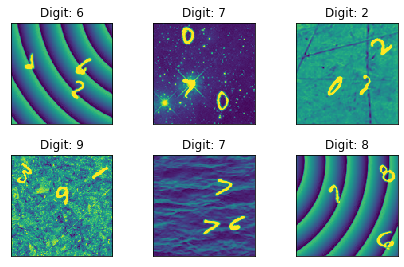

In [67]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(train_images[i], interpolation='none')
  plt.title("Digit: {}".format(labels.iloc[i,1]))
  plt.xticks([])
  plt.yticks([])

In [68]:
print((train_images[0].shape))

(128, 128)


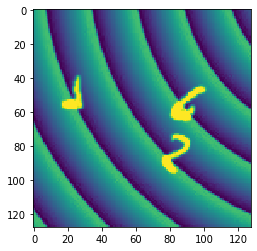

In [69]:
plt.imshow(train_images[0])

In [70]:
type(train_images)

numpy.ndarray

In [71]:
print(train_images[0])

[[144. 153. 161. ...  58.  62.  67.]
 [144. 152. 160. ...  51.  59.  64.]
 [143. 151. 158. ...  46.  57.  62.]
 ...
 [160. 176. 172. ... 155. 163. 162.]
 [161. 167. 172. ... 147. 153. 154.]
 [156. 163. 168. ... 142. 147. 149.]]


In [0]:
X_train = train_images.copy()

In [0]:
X_test = test_images.copy()

In [74]:
type(X_train)

numpy.ndarray

In [0]:
# Removing unnecessary features from training images 
for i in range(X_train.shape[0]):
  ret,bin = cv2.threshold(X_train[i],230,255,cv2.THRESH_BINARY)
  X_train[i] = bin

In [0]:
# Removing unnecessary features from testing images 
for i in range(X_test.shape[0]):
  ret,bin = cv2.threshold(X_test[i],230,255,cv2.THRESH_BINARY)
  X_test[i] = bin;

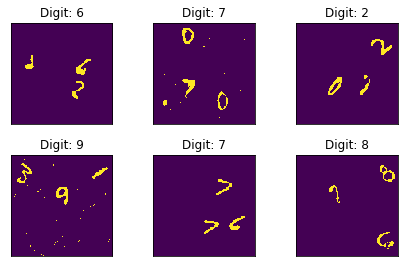

In [77]:
# Updated images
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], interpolation='none')
  plt.title("Digit: {}".format(labels.iloc[i,1]))
  plt.xticks([])
  plt.yticks([])

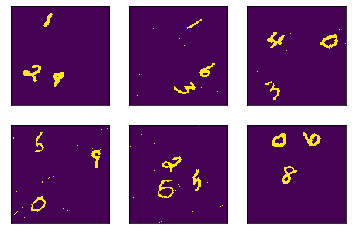

In [78]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(X_test[i], interpolation='none')
  plt.xticks([])
  plt.yticks([])

In [0]:
# Reshaping and normalising data for CNN
X_train = X_train.reshape(X_train.shape[0], 128, 128, 1)
input_shape = (128, 128, 1)
# Making sure that the values are float so that we can get decimal points after division
X_train = X_train.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
X_train /= 255.0

In [0]:
X_test = X_test.reshape(X_test.shape[0], 128, 128, 1)
X_test = X_test.astype('float32')
X_test /= 255.0

In [0]:
y_train = labels.iloc[:,1]

In [82]:
print(y_train.max())

9


In [0]:
# Converting output to categorical columns
y_train = np_utils.to_categorical(y_train)

In [86]:
print(y_train[2].argmax())

2


In [85]:
print(X_train[2].mean())

0.026916504


In [0]:
###################### Model 1 starts (Garbage model) ############################
input_shape = Input(shape=input_shape) 
layer1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_shape) 
layer2 = Conv2D(64, (3, 3), activation='relu')(layer1) 
layer3 = MaxPooling2D(pool_size=(3, 3))(layer2) 
layer4 = Dropout(0.5)(layer3) 
layer5 = Flatten()(layer4) 
layer6 = Dense(250, activation='sigmoid')(layer5) 
layer7 = Dense(150, activation='sigmoid')(layer6) 
layer8 = Dense(10, activation='softmax')(layer7) 

In [0]:
model = Model([input_shape], layer8) 
model.compile(optimizer=keras.optimizers.Adadelta(), 
              loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy']) 
  
model.fit(X_train, y_train, epochs=25, batch_size=500) 


In [32]:
pred = model.predict(X_test, verbose=1)

10000/10000 [==============================] - 7s 723us/step


In [0]:
pred_class = np.argmax(pred,axis=1)

In [34]:
pred_class[:40]

array([7, 8, 9, 8, 6, 9, 8, 6, 8, 9, 9, 9, 6, 8, 7, 4, 8, 3, 9, 9, 5, 8,
       9, 7, 7, 5, 7, 9, 9, 8, 8, 9, 9, 8, 9, 4, 7, 3, 8, 8])

In [0]:
test_preds = pd.DataFrame()

In [0]:
test_preds['Id'] = range(10000)

In [0]:
test_preds['Label'] = pred_class

In [38]:
test_preds.head(20)

,Id,Label
0,0,7
1,1,8
2,2,9
3,3,8
4,4,6
5,5,9
6,6,8
7,7,6
8,8,8
9,9,9


In [0]:
test_preds.to_csv("test.csv", index=False)

In [0]:
from google.colab import files

files.download("test.csv")

################## Model 1 ends #############################

In [0]:
print(X_train.shape)

In [0]:
##################### Model 2 starts (Garbage model) ####################
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(128, 128, 1)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# fit model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2)

##################### Model 2 ends ########################

In [0]:
###################### Model 3 start (Best till now) ####################
#################(Using pre trained vgg in cnn.....taking long to run on colab) ########

# Did below to make gray as rgb (VGG requires 3 channels)
X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, -1)

In [0]:
X_train_rgb = X_train_rgb.reshape(50000, 128, 128, 3)

In [0]:
image_shape_rgb = (128,128,3)
# num classes = total labels
num_classes = 10
from IPython.display import SVG


In [132]:
# Pre trained VGG19
vgg_model = applications.VGG19(include_top=False, weights='imagenet', input_shape=image_shape_rgb)
display(vgg_model.summary())
bottleneck_path = r'../working/bottleneck_features_train_vgg19.npy'

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

None

In [134]:
# Set to false the layers except the last set of conv laer and their pooling
for layer in vgg_model.layers[:-5]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f43fe6fd908> False
<keras.layers.convolutional.Conv2D object at 0x7f4401516860> False
<keras.layers.convolutional.Conv2D object at 0x7f440151d438> False
<keras.layers.pooling.MaxPooling2D object at 0x7f43fe71e1d0> False
<keras.layers.convolutional.Conv2D object at 0x7f43fe6c7a58> False
<keras.layers.convolutional.Conv2D object at 0x7f43fe6e0c50> False
<keras.layers.pooling.MaxPooling2D object at 0x7f43fe684780> False
<keras.layers.convolutional.Conv2D object at 0x7f43fe6ac588> False
<keras.layers.convolutional.Conv2D object at 0x7f43fe64b278> False
<keras.layers.convolutional.Conv2D object at 0x7f43fe668470> False
<keras.layers.convolutional.Conv2D object at 0x7f43fe61a160> False
<keras.layers.pooling.MaxPooling2D object at 0x7f43fe5cd400> False
<keras.layers.convolutional.Conv2D object at 0x7f43fe57a198> False
<keras.layers.convolutional.Conv2D object at 0x7f43fe598668> False
<keras.layers.convolutional.Conv2D object at 0x7f43fe536668>

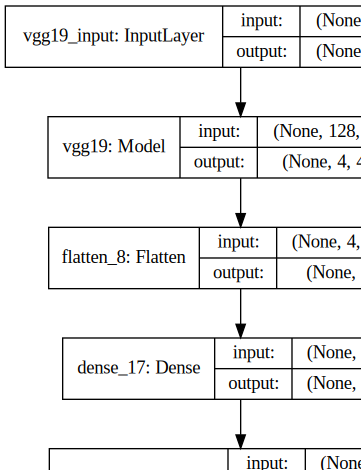

In [135]:
# fix random seed for reproducibility
seed = 101
np.random.seed(seed)

# Create the model
clf_model = Sequential()
 
# Add the vgg convolutional base model
#clf_model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
clf_model.add(vgg_model)

# Add new layers
clf_model.add(Flatten())
clf_model.add(Dense(1024, activation='relu'))
clf_model.add(Dropout(0.5))
clf_model.add(Dense(num_classes, activation='softmax'))

SVG(model_to_dot(clf_model, show_shapes=True, show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

In [136]:
#training
batch_size = 128
epochs = 25
lrate = 0.1
epsilon=1e-08
decay=1e-4
#opt_rms = optimizers.rmsprop(lr=lrate,decay=1e-4)
optimizer = keras.optimizers.Adadelta(lr=lrate ) # decay=decay) #, epsilon=epsilon, 
#optimizer = keras.optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=epsilon, decay=decay)

clf_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = clf_model.fit(X_train_rgb, y_train, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/25
50000/50000 [==============================] - 208s 4ms/step - loss: 1.5135 - acc: 0.4658
Epoch 2/25
50000/50000 [==============================] - 189s 4ms/step - loss: 0.6907 - acc: 0.7768
Epoch 3/25
50000/50000 [==============================] - 189s 4ms/step - loss: 0.4287 - acc: 0.8661
Epoch 4/25
50000/50000 [==============================] - 189s 4ms/step - loss: 0.3042 - acc: 0.9056
Epoch 5/25
50000/50000 [==============================] - 189s 4ms/step - loss: 0.2314 - acc: 0.9284
Epoch 6/25
50000/50000 [==============================] - 189s 4ms/step - loss: 0.1862 - acc: 0.9424
Epoch 7/25
50000/50000 [==============================] - 189s 4ms/step - loss: 0.1453 - acc: 0.9551
Epoch 8/25
50000/50000 [==============================] - 189s 4ms/step - loss: 0.1099 - acc: 0.9668
Epoch 9/25
50000/50000 [==============================] - 189s 4ms/step - loss: 0.0846 - acc: 0.9736
Epoch 10/25
50000/50000 [==============================] - 189s 4ms/step - loss: 0.0644 - a

In [0]:
######## Getting predictions from model 3

In [0]:
X_test_rgb = np.repeat(X_test[..., np.newaxis], 3, -1)

In [0]:
X_test_rgb = X_test_rgb.reshape(10000, 128, 128, 3)

In [139]:
pred = clf_model.predict(X_test_rgb, verbose=1)
pred_class = np.argmax(pred,axis=1)
print(pred_class[:40])

10000/10000 [==============================] - 43s 4ms/step
[9 6 4 9 8 8 2 4 5 9 4 9 9 9 9 6 8 7 4 6 7 7 6 5 8 9 5 6 8 6 7 9 3 8 7 6 6
 7 8 8]


In [0]:
# Saving predicted probabilities which could be used in future for writing meta classifier over it and some other model(probably)
import pickle

###Load into file
with open("vgg19_pred_probability.pkl","wb") as f:
    pickle.dump(pred,f)

###Extract from file
with open("vgg19_pred_probability.pkl","rb") as f:
    data_pred = pickle.load(f)

False

In [188]:
# Just for testing
pred_class_save = np.argmax(data_pred,axis=1)
print(np.any(pred_class_save == pred_class)==False)

False


In [140]:
# Saving prediction for kaggle
test_preds = pd.DataFrame()
test_preds['Id'] = range(10000)
test_preds['Label'] = pred_class
print(test_preds.head(20))

    Id  Label
0    0      9
1    1      6
2    2      4
3    3      9
4    4      8
5    5      8
6    6      2
7    7      4
8    8      5
9    9      9
10  10      4
11  11      9
12  12      9
13  13      9
14  14      9
15  15      6
16  16      8
17  17      7
18  18      4
19  19      6


In [0]:
test_preds.to_csv("vgg19_pred.csv", index=False)
from google.colab import files

files.download("vgg19_pred.csv")
################### Model 3 ends ###################

In [0]:
######################## Model 4 starts (Trying to stack two pre trained models (but was unable to try))
conv_base = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=image_shape_rgb)

In [0]:
vgg_model = applications.VGG19(include_top=False, weights='imagenet', input_shape=image_shape_rgb)

In [0]:
for layer in vgg_model.layers[:]:
    layer.trainable = False

In [0]:
for layer in conv_base.layers[:-5]:
    layer.trainable = False

In [124]:
for layer in vgg_model.layers:
    print(layer, layer.trainable)

for layer in conv_base.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f44143661d0> False
<keras.layers.convolutional.Conv2D object at 0x7f44143662e8> False
<keras.layers.convolutional.Conv2D object at 0x7f46636dd400> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4414432278> False
<keras.layers.convolutional.Conv2D object at 0x7f441440c9e8> False
<keras.layers.convolutional.Conv2D object at 0x7f4414337278> False
<keras.layers.pooling.MaxPooling2D object at 0x7f4414370630> False
<keras.layers.convolutional.Conv2D object at 0x7f4414368a58> False
<keras.layers.convolutional.Conv2D object at 0x7f44143577b8> False
<keras.layers.convolutional.Conv2D object at 0x7f4414354710> False
<keras.layers.convolutional.Conv2D object at 0x7f4414340550> False
<keras.layers.pooling.MaxPooling2D object at 0x7f44143b67f0> False
<keras.layers.convolutional.Conv2D object at 0x7f44143c1828> False
<keras.layers.convolutional.Conv2D object at 0x7f44143c1e48> False
<keras.layers.convolutional.Conv2D object at 0x7f44143cb4a8>

In [0]:
### Ran only InceptionResNetV2 stacked model
clf_model = Sequential()
 
# Add the vgg convolutional base model
#clf_model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
clf_model.add(conv_base)
# Add new layers
clf_model.add(Flatten())
clf_model.add(Dense(1024, activation='relu'))
clf_model.add(Dropout(0.5))
clf_model.add(Dense(num_classes, activation='softmax'))

In [130]:
batch_size = 128
epochs = 25
lrate = 0.1
epsilon=1e-08
decay=1e-4
optimizer = keras.optimizers.Adadelta(lr=lrate ) 
clf_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = clf_model.fit(X_train_rgb, y_train, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/25
50000/50000 [==============================] - 213s 4ms/step - loss: 1.8068 - acc: 0.3270
Epoch 2/25
50000/50000 [==============================] - 180s 4ms/step - loss: 1.6114 - acc: 0.4016
Epoch 3/25
50000/50000 [==============================] - 180s 4ms/step - loss: 1.5188 - acc: 0.4434
Epoch 4/25
50000/50000 [==============================] - 180s 4ms/step - loss: 1.4453 - acc: 0.4715
Epoch 5/25
50000/50000 [==============================] - 180s 4ms/step - loss: 1.3754 - acc: 0.4970
Epoch 6/25
50000/50000 [==============================] - 180s 4ms/step - loss: 1.3121 - acc: 0.5220
Epoch 7/25
50000/50000 [==============================] - 180s 4ms/step - loss: 1.2464 - acc: 0.5475
Epoch 8/25
50000/50000 [==============================] - 180s 4ms/step - loss: 1.1715 - acc: 0.5758
Epoch 9/25
50000/50000 [==============================] - 180s 4ms/step - loss: 1.1023 - acc: 0.6017
Epoch 10/25
50000/50000 [==============================] - 180s 4ms/step - loss: 1.0240 - a

In [131]:
pred = clf_model.predict(X_test_rgb, verbose=1)
pred_class = np.argmax(pred,axis=1)
print(pred_class[:40])

10000/10000 [==============================] - 68s 7ms/step
[9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 6 9 9
 9 9 9]


In [0]:
test_preds = pd.DataFrame()
test_preds['Id'] = range(10000)
test_preds['Label'] = pred_class
print(test_preds.head(20))

In [0]:
test_preds.to_csv("test.csv", index=False)
from google.colab import files

files.download("test.csv")
################# Model 4 ends ################